In [1]:
using Random
using StatsPlots
using Distributions

## Dirichlet Process Mixture
With $f(Y_i\, | \mu_i) = \mathrm{N}(Y_i; \mu_i, 1)$ and $P_0= \mathrm{N}(\bar{Y}, R^3)$, the posterior distribution is
$$ \mathbb{P} \left( \mu_i \in \cdot \, \big| \, \mu_{-i}^{(n)}, Y^{(n)}\right) = q_{i,0}^* \mathrm{N} \left( \mu_i \in \cdot \Big | \frac{R^3Y_i + \bar{Y}}{1+R^3}, \frac{R^3}{1+R^3} \right) + \sum_{j=1}^k q_{i,j}^* \delta_{X_j}(\cdot)$$

where
$$ q_{i,0}^* \propto \theta \, \mathrm{N}( \cdot \,| \bar{Y}, R^3+1)$$

$$ q_{i,j}^* \propto n_j \, \mathrm{N}( \cdot \,| \mu_j^*, 1)$$


In [2]:
# Kernel
function kernel(y, μ)
    return pdf(Normal(μ, 1), y)
end



# Random value from posterior CREO QUE v es el rango
function rposterior(yi, m, v)
    return rand(Normal((m*v + sum(yi))/(v + length(yi)), 1/sqrt(v+length(yi))), 1)[1]
end



#Weights
function q0(yi, theta, m, v)
    return theta*sqrt(v/(2*π*(v+1)))*exp(-v*(yi-m)^2/(2*(v+1))) #Variance R^3/R^3+1 y media m
end

function qj(yi, nj, muj) 
  return nj*kernel(yi, muj)
end 



# Choose either generating a new value (i = 0) or a repeated value (i - 1)
function rweight(yi, theta, mus, ns, mu0, v0)
  ni = length(ns)
  qq = zeros(ni+1)
  qq[1] = q0(yi, theta, mu0, v0)
  sumqq = qq[1]
  
  for i = 1:ni 
    qq[i+1] = qj(yi, ns[i], mus[i])
    sumqq = sumqq + qq[i+1]
    end 
    
  u = rand(Uniform(), 1)[1]*sumqq
  i = 1
  acum =  qq[i]
  while u > acum
    i = i + 1
    acum = acum + qq[i]
    end  
  i-1
end 


# Acceleration step
function actualizeMu(y,mus,cc,mu0,v0)
    mm = mus
    for i = 1:length(mm) 
        mm[i] = rposterior(y[findall(cc.==i)], mu0, v0)
    end 
    return mm
end 

actualizeMu (generic function with 1 method)

In [22]:
# MCMC 
function iteration(y, theta, mus, ns, cc, mu0, v0) 
    n = length(y)
    nn = []
    mm = []
    
    for i=1:n
        #print("\n ns length: ", length(ns))
        #if length(ns) >= cc[i]
        if ns[cc[i]] == 1
            nn = ns[1:end .!= cc[i]]
            mm = mus[1:end .!= cc[i]]
        else 
            nn = ns
            nn[cc[i]] -= 1
            mm = mus
        end 
        j = rweight(y[i], theta, mm, nn, mu0, v0)
        if cc[i] == j 
            continue 
        end 
        mu_upd = 0
        if j == 0 #Simulate from posterior
            mu_upd = rposterior(y[i], mu0, v0)
            if ns[cc[i]] == 1
                mus[cc[i]] = mu_upd 
            else 
                append!(mus, mu_upd)
                ns[cc[i]] -= 1
                append!(ns, 1) 
                cc[i] = length(ns)
            end 
        else  
            ns[j] += 1 
            ns[cc[i]] -= 1 
            if ns[cc[i]]==0 
                deleteat!(ns, cc[i]) 
                deleteat!(mus, cc[i])
                #ns = ns[1:end .!= cc[i]]
                #mus = mus[1:end .!= cc[i]]
                cc[cc .>cc[i]].-=  1 #cc[cc .>cc[i]] - 1
                cc[i] = cc[i]>j ? j : j-1
            else 
                cc[i] = j
            end
        end 
        #end
    end
    mus = actualizeMu(y, mus, cc, mu0, v0)
    return(mu = mus, ns = ns, cc = cc) 
end

iteration (generic function with 1 method)

In [4]:
function mcmc(y, theta, mu0, v0, burn, sample) 
    n = length(y)
    MM = []
    NN = []
    CC = zeros(sample, n)
    KK = zeros(sample)
    mm = rand(Normal(mu0, 1/sqrt(v0)), n) # initial values
    cc = hcat(1:n...) #memberships 
    ns = ones(n)
    
    if burn>0 
        print("BURNING-IN")
        for i=1:burn 
            rr = iteration(y, theta, mm, ns, cc, mu0, v0)
            mm = rr.mu 
            ns = rr.ns
            cc = rr.cc
        end
    end
    
    if sample>0 
    print("SAMPLING")
    for i=1:sample
            rr = iteration(y, theta, mm, ns, cc, mu0, v0)
            mm = rr.mu
            ns = rr.ns
            cc = rr.cc
            KK[i] = length(ns)
            append!(MM, mm) # ESTO LO HACE INPLACE
            append!(NN, ns)
            CC[i,:] = cc
        end 
    end 
  return(mu = MM, ns = NN, cc = CC, k = KK)
end 

mcmc (generic function with 1 method)

In [5]:
# Density estimation
function dens(mcmc, ymin, ymax, grid)
    yy = range(ymin, ymax, length = grid)
    ff = zeros(grid)
    SS = size(mcmc.cc, 1) #nrows
    nn = size(mcmc.cc, 2) #ncols
    k0 = 0
    for i=1:SS
        kk = Int(mcmc.k[i]) 
        for j=1:kk+k0
            for l=1:grid
                ff[l] += mcmc.ns[j]*kernel(yy[l], mcmc.mu[j])
            end
        end
        k0 += kk
    end
    return((yy, ff./(SS*nn)))
end 

# Posterior of K_n
function posteriorKn(mcmc) 
    unq = sort(unique(mcmc.k)) #AQUI TAL BEZ NESESITO PONER DIMS = 1 o 2
    p = zeros(length(unq))
    n = length(mcmc.k)
    for i=1:length(unq)
        p[i] = count(==(unq[i]), mcmc.k)/n
    end
    print("\n Unique, p: ", (unq, p))
    return((unq, p))
end 


posteriorKn (generic function with 1 method)

### Toy dataset
Sample 100 points from $ 0.33 \, \mathrm{N}(-8,1) + 0.35 \, \mathrm{N}(0,1) + 0.32\, \mathrm{N}(8,1)$

In [6]:
Random.seed!(12345)
w = vcat(rand(Normal(-8,1), 33), rand(Normal(0,1), 35), rand(Normal(8,1), 32))
y = sort!(permutedims(w), dims = 2)

#R = maximum(y) - minimum(y)

1×100 Array{Float64,2}:
 -10.1476  -9.52016  -9.47708  -9.30436  …  8.87074  8.95192  9.10144  9.7179

In [23]:
sim = mcmc(y, 0.2, 0, 0.1, 0, 5000) 

SAMPLING

BoundsError: BoundsError: attempt to access 4-element Array{Float64,1} at index [5]

In [8]:
density_est = dens(sim,-11,11,80)

(-11.0:0.27848101265822783:11.0, [0.0035945134590919013, 0.0100602399234141, 0.026258388547845273, 0.0638611491701435, 0.1446196853098916, 0.3048092067248223, 0.5977010789889364, 1.0901441160705054, 1.8490509250718494, 2.916249463395446  …  0.059361717686197954, 0.05099226781482819, 0.041136680883912986, 0.0311035474927628, 0.021998247023388984, 0.014526539284892913, 0.008941615826758311, 0.005123088280558772, 0.0027289231281442893, 0.001350108440843725])

In [14]:
maximum(density_est[2])

9.72433666565841

In [21]:
post = posteriorKn(sim)


 Unique, p: ([1.0, 3.0, 15.0], [0.6, 0.2, 0.2])

([1.0, 3.0, 15.0], [0.6, 0.2, 0.2])

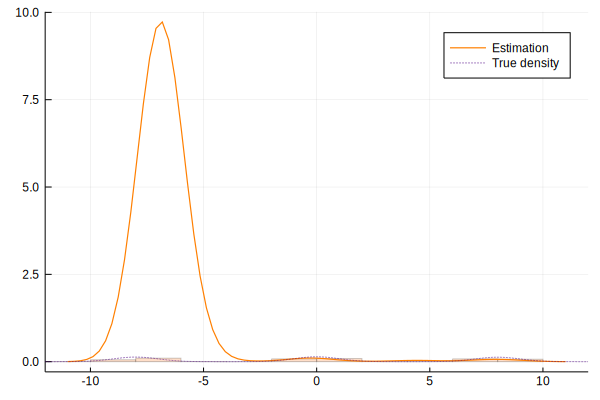

In [12]:
#gr(background_colour_inside = :whitesmoke)
p = histogram(w, bins = 16, normalized = true, linealpha = 0.2, fillalpha = 0.25, color = :chocolate1, label = nothing)
plot!(p, density_est, label = "Estimation", color = :darkorange1, linewidth = 1.2)

t = MixtureModel(Normal.([-8, 0, 8], [1, 1, 1]), [0.33, 0.35, 0.32])
xs = -12:0.01:12
plot!(p, xs, pdf.(t, xs), label = "True density", linestyle = :dot, color = :indigo)
xlims!((-12, 12))

In [ ]:
using ColorSchemes


#theta = [0.2, 0.5, 1, 3]
theta = 0.2
sample_size = [5, 10, 100, 1000, 5000]


p = histogram(w, bins = 16, normalized = true, linealpha = 0.2, fillalpha = 0.25, 
    color = :gray, label = nothing, title = "\\theta ="*string(theta))
    
for k=1:length(sample_size)
    c = get(ColorSchemes.rose, k/length(sample_size))
    sim = mcmc(y, theta, 0, 0.1, 0, sample_size[k])
    density_est = dens(sim,-11,11,100)
    plot!(p, density_est, label = "N="*string(sample_size[k]), color = c, linewidth = 1)
    posterior = posteriorKn(sim) 
end


In [ ]:
p

In [ ]:
# Con burn in
theta = 1

p = histogram(w, bins = 16, normalized = true, linealpha = 0.2, fillalpha = 0.25, 
    color = :gray, label = nothing, title = "\\theta ="*string(theta))

vars = [100, 500, 1000, 5000, 20000]
for k=1:length(vars)
    c = get(ColorSchemes.candy, rand(Uniform(), 1)[1])
    sim = mcmc(y, theta, 0, 0.1, 2000, 10000)
    density_est = dens(sim,-11,11,100)
    plot!(p, density_est, label = "\\sigma^2="*string(vars[k]), color = c, linewidth = 1)
    posterior = posteriorKn(sim) 
end



In [ ]:
sim = mcmc(y, 0.2, 0, 0.1, 0, 5000)
density_est = dens(sim,-20,20,150)
plot(density_est, linewidth = 1)

## $\sigma$- stable Process Mixture

Aqui poner la predictiva ahoraps

In [ ]:
#Weights for stable process
function q0_stable(yi, sigma, m, v)
    return sigma*sqrt(v/(2*π*(v+1)))*exp(-v*(yi-m)^2/(2*(v+1))) #Variance R^3/R^3+1 y media m
end

function qj_stable(yi, nj, muj, sigma) 
  return (nj-sigma)*kernel(yi, muj)
end 
